# Assignment 4: Flower Classification with Pretrained CNNs

This notebook uses VGG19 to classify flower types from the Flowers-102 dataset.

## Requirements:
- PyTorch
- Model: VGG19
- Dataset: Oxford Flowers-102
- Random split: 50% train / 25% val / 25% test
- Two different random seeds for repeated experiments: 42 and 123
- Probabilistic output: softmax probabilities for each class

## Setup and Installation

In [ ]:
# Install required packages
!pip install -q torch torchvision matplotlib numpy scipy scikit-learn pillow
import os

print("✅ Setup complete!")

✅ Setup complete!


## Download Oxford Flowers-102 Dataset

Download and extract the dataset if not already present.

In [ ]:
import urllib.request
import tarfile
from pathlib import Path

# Create data directory
data_dir = Path('data/flowers-102')
data_dir.mkdir(parents=True, exist_ok=True)

# Download dataset files if not present
if not (data_dir / 'jpg').exists():
    print("Downloading dataset images...")
    img_url = 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz'
    urllib.request.urlretrieve(img_url, 'data/102flowers.tgz')
    with tarfile.open('data/102flowers.tgz', 'r:gz') as tar:
        tar.extractall('data/flowers-102')

if not (data_dir / 'imagelabels.mat').exists():
    print("Downloading labels...")
    label_url = 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat'
    urllib.request.urlretrieve(label_url, str(data_dir / 'imagelabels.mat'))

if not (data_dir / 'setid.mat').exists():
    print("Downloading setid...")
    setid_url = 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat'
    urllib.request.urlretrieve(setid_url, str(data_dir / 'setid.mat'))

print("Dataset ready!")

/tmp/ipython-input-2408700813.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall('data/flowers-102')


Dataset ready!


## Import Libraries and Define Configuration

In [ ]:
from __future__ import annotations

import csv
import os
import shutil
import subprocess
import sys
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from scipy.io import loadmat

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu126
CUDA available: True


In [ ]:
@dataclass(frozen=True)
class Config:
    data_dir: str = "data"
    img_size: int = 224
    batch_size: int = 32  # smaller for better generalization
    vgg19_epochs: int = 50  # train longer
    lr: float = 1e-4
    weight_decay: float = 1e-4  # L2 regularization
    dropout: float = 0.5  # added before classifier
    num_workers: int = 0  # adjust if not on Colab
    num_classes: int = 102
    split_repeats: Tuple[int, int] = (42, 123)

cfg = Config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Configuration: {cfg}")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Configuration: Config(data_dir='data', img_size=224, batch_size=32, vgg19_epochs=50, lr=0.0001, weight_decay=0.0001, dropout=0.5, num_workers=0, num_classes=102, split_repeats=(42, 123))
Using device: cuda
GPU: Tesla T4


## Data Loading and Image Preprocessing Pipeline

### Training Set Preprocessing Steps:

1. **Resize**: All images are resized to 224×224 pixels (standard input size for VGG19 and most pretrained models)

2. **Data Augmentation** (training only):
   - **Random Horizontal Flip**: 50% probability of flipping images horizontally to increase data diversity
   - **Random Rotation**: Random rotation up to ±20 degrees to help model learn rotation invariance
   - **Color Jitter**:
     - Brightness variation: ±20% to handle different lighting conditions
     - Contrast variation: ±20% to handle different exposure levels

3. **Convert to Tensor**: PIL Image → PyTorch tensor (H×W×C → C×H×W format)

4. **Normalization**:
   - Mean subtraction: [0.485, 0.456, 0.406] per channel (R, G, B)
   - Standard deviation division: [0.229, 0.224, 0.225] per channel
   - These are ImageNet statistics, which work well for transfer learning from ImageNet-pretrained models

### Validation/Test Set Preprocessing Steps:

1. **Resize**: 224×224 pixels (same as training)
2. **Convert to Tensor**: PIL Image → PyTorch tensor
3. **Normalization**: Same ImageNet statistics as training

**No data augmentation** is applied to validation/test sets to ensure consistent evaluation.

### Rationale:
- Resize to 224×224 matches the input size that VGG19 was pretrained on
- Data augmentation during training helps prevent overfitting and improves generalization
- ImageNet normalization enables effective transfer learning from pretrained weights

In [ ]:
def get_transforms(img_size: int):
    train_tf = transforms.Compose(
        [
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    eval_tf = transforms.Compose(
        [
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    return train_tf, eval_tf


def load_flowers102_paths_and_labels(flowers_root: Path) -> Tuple[List[Path], np.ndarray]:
    """Load (image_paths, labels_0indexed) for all images."""
    labels_mat = loadmat(flowers_root / "imagelabels.mat")
    labels_1indexed = np.asarray(labels_mat["labels"]).reshape(-1).astype(np.int64)
    labels_0indexed = labels_1indexed - 1

    img_dir = flowers_root / "jpg"
    image_paths = [img_dir / f"image_{i:05d}.jpg" for i in range(1, labels_0indexed.shape[0] + 1)]
    missing = [p for p in image_paths if not p.is_file()]
    if missing:
        raise FileNotFoundError(f"Missing {len(missing)} images under {img_dir}. Example: {missing[0]}")

    return image_paths, labels_0indexed


def stratified_split(
    image_paths: List[Path],
    labels: np.ndarray,
    seed: int,
    train_frac: float = 0.50,
    val_frac: float = 0.25,
    test_frac: float = 0.25,
):
    if abs((train_frac + val_frac + test_frac) - 1.0) > 1e-9:
        raise ValueError("train/val/test fractions must sum to 1.0")

    y = labels
    idx_all = np.arange(len(image_paths))

    sss_1 = StratifiedShuffleSplit(n_splits=1, test_size=(val_frac + test_frac), random_state=seed)
    train_idx, temp_idx = next(sss_1.split(idx_all, y))

    y_temp = y[temp_idx]
    val_rel = val_frac / (val_frac + test_frac)
    sss_2 = StratifiedShuffleSplit(n_splits=1, test_size=(1 - val_rel), random_state=seed + 1)
    val_sub, test_sub = next(sss_2.split(temp_idx, y_temp))
    val_idx = temp_idx[val_sub]
    test_idx = temp_idx[test_sub]

    def take(indices: np.ndarray):
        return [image_paths[i] for i in indices], y[indices]

    x_train, y_train = take(train_idx)
    x_val, y_val = take(val_idx)
    x_test, y_test = take(test_idx)
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)


class PathDataset(Dataset):
    def __init__(self, paths: List[Path], labels: np.ndarray, transform):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        x = self.transform(img)
        y = int(self.labels[idx])
        return x, y

## Load and Split Dataset

In [ ]:
flowers_root = Path(cfg.data_dir) / "flowers-102"
image_paths, labels = load_flowers102_paths_and_labels(flowers_root)

print(f"Total images: {len(image_paths)}")
print(f"Number of classes: {len(np.unique(labels))}")
print(f"Label range: {labels.min()} to {labels.max()}")

Total images: 8189
Number of classes: 102
Label range: 0 to 101


## VGG19 Network Architecture

### Model Overview
The model is based on VGG19, a 19-layer deep convolutional neural network pretrained on the ImageNet dataset (1,000 classes). Transfer learning is applied by freezing the pretrained feature extraction layers and training the classifier for the Flowers-102 task.

### Architecture Summary
- **Feature extractor (frozen)**:  
  Five convolutional blocks with a total of **16 Conv2D layers**  
  (3×3 kernels, ReLU activations), each followed by **MaxPool2D (2×2)**.
- **Classifier layers**:
  
  The VGG19 classifier is retained and adapted for the Flowers-102 dataset by replacing the final fully connected layer (4096 → 102):
  1. Linear (25088 → 4096) + ReLU + Dropout (0.5)
  2. Linear (4096 → 4096) + ReLU + Dropout (0.5)
  3. Linear (4096 → 102)

The final fully connected layer is replaced with a layer that outputs 102 flower classes.

### Transfer Learning Strategy
* **Frozen layers**: All convolutional layers
* **Trainable layers**: Classifier layers
* **Output**: 102 class logits, converted to probabilities using the softmax function during inference

### Training Configuration
- **Input**: Images resized to **224×224**
- **Model**: VGG19, trained for **50 epochs**
- **Batch size**: **32**
- **Optimizer**: SGD (learning rate = **1e-4**)
- **Loss function**: Cross-Entropy Loss
- **Probabilistic Output**: Softmax applied to logits
- **Evaluation robustness**: Training repeated on **two random data splits**  
  (seeds **42** and **123**) and results averaged

In [ ]:
def build_vgg19(num_classes: int) -> nn.Module:
    model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
    for p in model.features.parameters():
        p.requires_grad = False

    # Replace the last classifier layer to output 102 logits
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
    return model


def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += float(loss.item()) * labels.size(0)
        preds = logits.argmax(dim=1)
        correct += int((preds == labels).sum().item())
        total += int(labels.size(0))
    return total_loss / max(total, 1), correct / max(total, 1)


@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += float(loss.item()) * labels.size(0)
        preds = logits.argmax(dim=1)
        correct += int((preds == labels).sum().item())
        total += int(labels.size(0))
    return total_loss / max(total, 1), correct / max(total, 1)


@torch.no_grad()
def predict_proba_vgg19(model: nn.Module, image_tensor: torch.Tensor) -> torch.Tensor:
    model.eval()
    logits = model(image_tensor)
    return torch.softmax(logits, dim=1)

## Visualization Functions

In [ ]:
def save_model_summary(model: nn.Module, out_path: Path):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    out_path.write_text(str(model) + "\n")


def plot_curves(history: Dict[str, List[float]], title: str, out_path: Path):
    out_path.parent.mkdir(parents=True, exist_ok=True)

    n_epochs = len(history["train_loss"])
    if not (
        len(history["val_loss"]) == n_epochs
        and len(history["test_loss"]) == n_epochs
        and len(history["train_acc"]) == n_epochs
        and len(history["val_acc"]) == n_epochs
        and len(history["test_acc"]) == n_epochs
    ):
        raise ValueError("All history curves must have the same length (one value per epoch).")

    epochs = range(1, n_epochs + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title)

    ax1.plot(epochs, history["train_loss"], label="train")
    ax1.plot(epochs, history["val_loss"], label="val")
    ax1.plot(epochs, history["test_loss"], label="test")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("cross-entropy loss")
    ax1.legend()

    ax2.plot(epochs, history["train_acc"], label="train")
    ax2.plot(epochs, history["val_acc"], label="val")
    ax2.plot(epochs, history["test_acc"], label="test")
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("accuracy")
    ax2.legend()

    fig.tight_layout()
    fig.savefig(out_path, dpi=150)
    plt.show()
    plt.close(fig)

In [ ]:
def train_vgg19_repeat(cfg: Config, repeat_seed: int, split_data, artifacts_dir: Path):
    (x_train, y_train), (x_val, y_val), (x_test, y_test) = split_data
    train_tf, eval_tf = get_transforms(cfg.img_size)

    train_loader = DataLoader(
        PathDataset(x_train, y_train, train_tf),
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
    )
    val_loader = DataLoader(
        PathDataset(x_val, y_val, eval_tf),
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
    )
    test_loader = DataLoader(
        PathDataset(x_test, y_test, eval_tf),
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = build_vgg19(cfg.num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        [p for p in model.parameters() if p.requires_grad],
        lr=cfg.lr,
        momentum=0.9,      # common default for SGD
        weight_decay=cfg.weight_decay,
        nesterov=True       # optional, often improves convergence
    )
    save_model_summary(model, artifacts_dir / f"vgg19_repeat_{repeat_seed}" / "model.txt")

    history = {
        "train_loss": [],
        "val_loss": [],
        "test_loss": [],
        "train_acc": [],
        "val_acc": [],
        "test_acc": [],
    }

    print(f"\n[VGG19] repeat seed={repeat_seed}")
    for epoch in range(cfg.vgg19_epochs):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        va_loss, va_acc = eval_one_epoch(model, val_loader, criterion, device)
        te_loss, te_acc = eval_one_epoch(model, test_loader, criterion, device)

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["test_loss"].append(te_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)
        history["test_acc"].append(te_acc)

        print(
            f"  epoch {epoch + 1:02d}/{cfg.vgg19_epochs} | "
            f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
            f"val loss {va_loss:.4f} acc {va_acc:.4f} | "
            f"test loss {te_loss:.4f} acc {te_acc:.4f}"
        )

    print(f"  Final test loss: {history['test_loss'][-1]:.4f}, test acc: {history['test_acc'][-1]:.4f}")

    out_dir = artifacts_dir / f"vgg19_repeat_{repeat_seed}"
    out_dir.mkdir(parents=True, exist_ok=True)
    torch.save(model.state_dict(), out_dir / "weights.pth")
    plot_curves(history, f"VGG19 (repeat seed={repeat_seed})", out_dir / "curves.png")

    # Example probabilistic prediction
    batch_images, _ = next(iter(test_loader))
    probs = predict_proba_vgg19(model, batch_images[:1].to(device))[0].detach().cpu().numpy()
    top5 = probs.argsort()[-5:][::-1]

    print("  example softmax top-5:")
    for idx in top5:
        print(f"    class_{idx:03d}: {probs[idx]:.4f}")

    return history

## Train VGG19 - First Run (Seed 42)

Split sizes (seed=42): train=4094, val=2047, test=2048
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:06<00:00, 88.0MB/s]



[VGG19] repeat seed=42
  epoch 01/50 | train loss 4.5398 acc 0.0376 | val loss 4.3094 acc 0.0821 | test loss 4.2982 acc 0.0874
  epoch 02/50 | train loss 4.2125 acc 0.0982 | val loss 4.0223 acc 0.1544 | test loss 4.0034 acc 0.1558
  epoch 03/50 | train loss 3.9338 acc 0.1556 | val loss 3.7382 acc 0.2189 | test loss 3.7139 acc 0.2124
  epoch 04/50 | train loss 3.6581 acc 0.2054 | val loss 3.4439 acc 0.3009 | test loss 3.4149 acc 0.2944
  epoch 05/50 | train loss 3.3748 acc 0.2621 | val loss 3.1571 acc 0.3801 | test loss 3.1278 acc 0.3823
  epoch 06/50 | train loss 3.0967 acc 0.3156 | val loss 2.8697 acc 0.4216 | test loss 2.8416 acc 0.4116
  epoch 07/50 | train loss 2.8496 acc 0.3586 | val loss 2.6137 acc 0.4636 | test loss 2.5850 acc 0.4678
  epoch 08/50 | train loss 2.5911 acc 0.4064 | val loss 2.3784 acc 0.5012 | test loss 2.3503 acc 0.5098
  epoch 09/50 | train loss 2.3758 acc 0.4560 | val loss 2.1757 acc 0.5413 | test loss 2.1447 acc 0.5483
  epoch 10/50 | train loss 2.1905 acc 0.

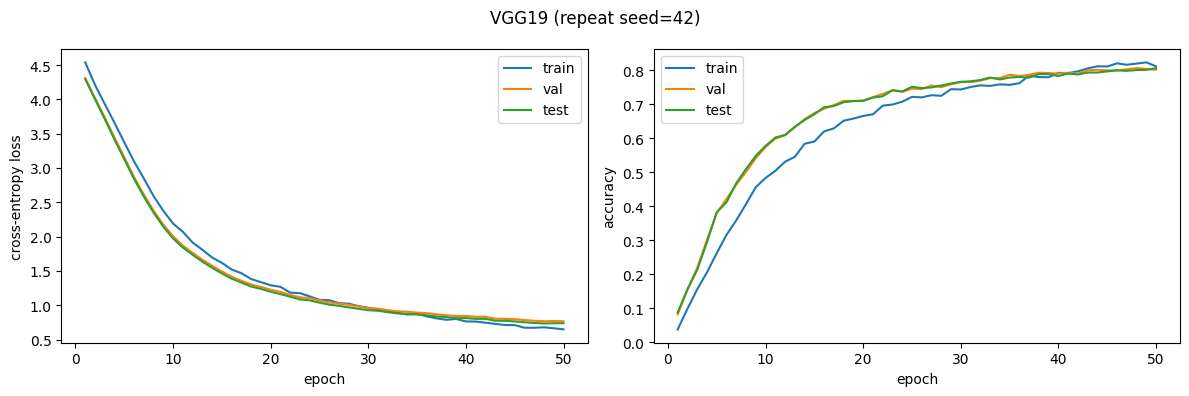

  example softmax top-5:
    class_023: 0.9298
    class_038: 0.0286
    class_012: 0.0118
    class_091: 0.0061
    class_092: 0.0046


In [ ]:
# Create artifacts directory
artifacts_dir = Path("artifacts")
artifacts_dir.mkdir(exist_ok=True)

# Train VGG19 with first seed
seed1 = cfg.split_repeats[0]
split_data1 = stratified_split(image_paths, labels, seed=seed1)
print(f"Split sizes (seed={seed1}): train={len(split_data1[0][0])}, val={len(split_data1[1][0])}, test={len(split_data1[2][0])}")

history_vgg19_1 = train_vgg19_repeat(cfg, seed1, split_data1, artifacts_dir)

## Train VGG19 - Second Run (Seed 123)

Split sizes (seed=123): train=4094, val=2047, test=2048

[VGG19] repeat seed=123
  epoch 01/50 | train loss 4.5290 acc 0.0364 | val loss 4.3071 acc 0.0884 | test loss 4.2994 acc 0.0898
  epoch 02/50 | train loss 4.2135 acc 0.0972 | val loss 4.0267 acc 0.1558 | test loss 4.0133 acc 0.1572
  epoch 03/50 | train loss 3.9520 acc 0.1558 | val loss 3.7477 acc 0.2233 | test loss 3.7293 acc 0.2217
  epoch 04/50 | train loss 3.6798 acc 0.2074 | val loss 3.4593 acc 0.2838 | test loss 3.4371 acc 0.2949
  epoch 05/50 | train loss 3.3773 acc 0.2738 | val loss 3.1594 acc 0.3493 | test loss 3.1338 acc 0.3706
  epoch 06/50 | train loss 3.1033 acc 0.3175 | val loss 2.8707 acc 0.4148 | test loss 2.8465 acc 0.4229
  epoch 07/50 | train loss 2.8324 acc 0.3649 | val loss 2.6147 acc 0.4538 | test loss 2.5884 acc 0.4717
  epoch 08/50 | train loss 2.6032 acc 0.4096 | val loss 2.3855 acc 0.4988 | test loss 2.3586 acc 0.5156
  epoch 09/50 | train loss 2.3881 acc 0.4511 | val loss 2.1901 acc 0.5310 | test loss 2

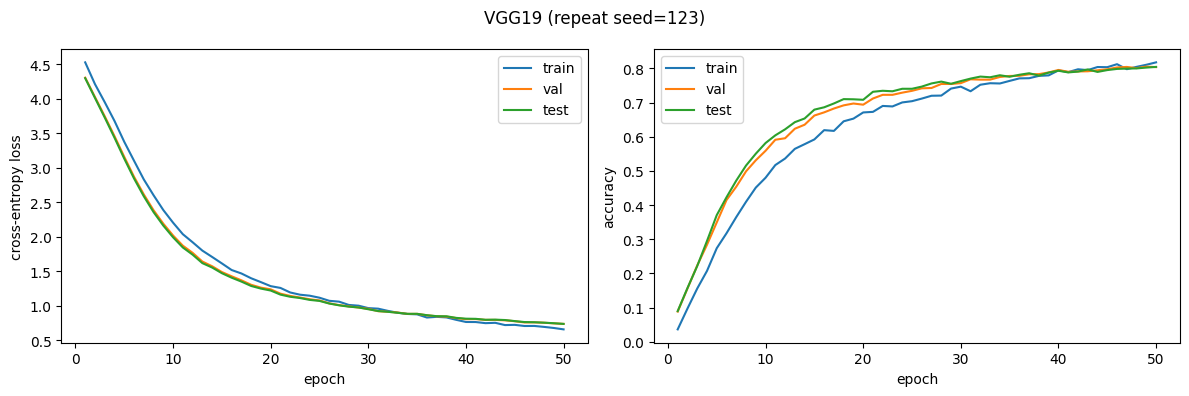

  example softmax top-5:
    class_075: 0.3871
    class_018: 0.1595
    class_074: 0.1126
    class_096: 0.0636
    class_063: 0.0610


In [ ]:
# Train VGG19 with second seed
seed2 = cfg.split_repeats[1]
split_data2 = stratified_split(image_paths, labels, seed=seed2)
print(f"Split sizes (seed={seed2}): train={len(split_data2[0][0])}, val={len(split_data2[1][0])}, test={len(split_data2[2][0])}")

history_vgg19_2 = train_vgg19_repeat(cfg, seed2, split_data2, artifacts_dir)

In [ ]:
# --- 1. Define Flower Names Mapping ---
# Mapping from Label ID (1-102) to English Name
FLOWER_NAMES = {
    '1': 'pink primrose', '2': 'hard-leaved pocket orchid', '3': 'canterbury bells', '4': 'sweet pea', '5': 'english marigold',
    '6': 'tiger lily', '7': 'moon orchid', '8': 'bird of paradise', '9': 'monkshood', '10': 'globe thistle',
    '11': 'snapdragon', '12': "colt's foot", '13': 'king protea', '14': 'spear thistle', '15': 'yellow iris',
    '16': 'globe-flower', '17': 'purple coneflower', '18': 'peruvian lily', '19': 'balloon flower', '20': 'giant white arum lily',
    '21': 'fire lily', '22': 'pincushion flower', '23': 'fritillary', '24': 'red ginger', '25': 'grape hyacinth',
    '26': 'corn poppy', '27': 'prince of wales feathers', '28': 'stemless gentian', '29': 'artichoke', '30': 'sweet william',
    '31': 'carnation', '32': 'garden phlox', '33': 'love in the mist', '34': 'mexican aster', '35': 'alpine sea holly',
    '36': 'ruby-lipped cattleya', '37': 'cape flower', '38': 'great masterwort', '39': 'siam tulip', '40': 'lenten rose',
    '41': 'barbeton daisy', '42': 'daffodil', '43': 'sword lily', '44': 'poinsettia', '45': 'bolero deep blue',
    '46': 'wallflower', '47': 'marigold', '48': 'buttercup', '49': 'oxeye daisy', '50': 'common dandelion',
    '51': 'petunia', '52': 'wild pansy', '53': 'primula', '54': 'sunflower', '55': 'pelargonium',
    '56': 'bishop of llandaff', '57': 'gaura', '58': 'geranium', '59': 'orange dahlia', '60': 'pink-yellow dahlia',
    '61': 'cautleya spicata', '62': 'japanese anemone', '63': 'black-eyed susan', '64': 'silverbush', '65': 'californian poppy',
    '66': 'osteospermum', '67': 'spring crocus', '68': 'bearded iris', '69': 'windflower', '70': 'tree poppy',
    '71': 'gazania', '72': 'azalea', '73': 'water lily', '74': 'rose', '75': 'thorn apple',
    '76': 'morning glory', '77': 'passion flower', '78': 'lotus', '79': 'toad lily', '80': 'anthurium',
    '81': 'frangipani', '82': 'clematis', '83': 'hibiscus', '84': 'columbine', '85': 'desert-rose',
    '86': 'tree mallow', '87': 'magnolia', '88': 'cyclamen', '89': 'watercress', '90': 'canna lily',
    '91': 'hippeastrum', '92': 'bee balm', '93': 'ball moss', '94': 'foxglove', '95': 'bougainvillea',
    '96': 'camellia', '97': 'mallow', '98': 'mexican petunia', '99': 'bromelia', '100': 'blanket flower',
    '101': 'trumpet creeper', '102': 'blackberry lily'
}

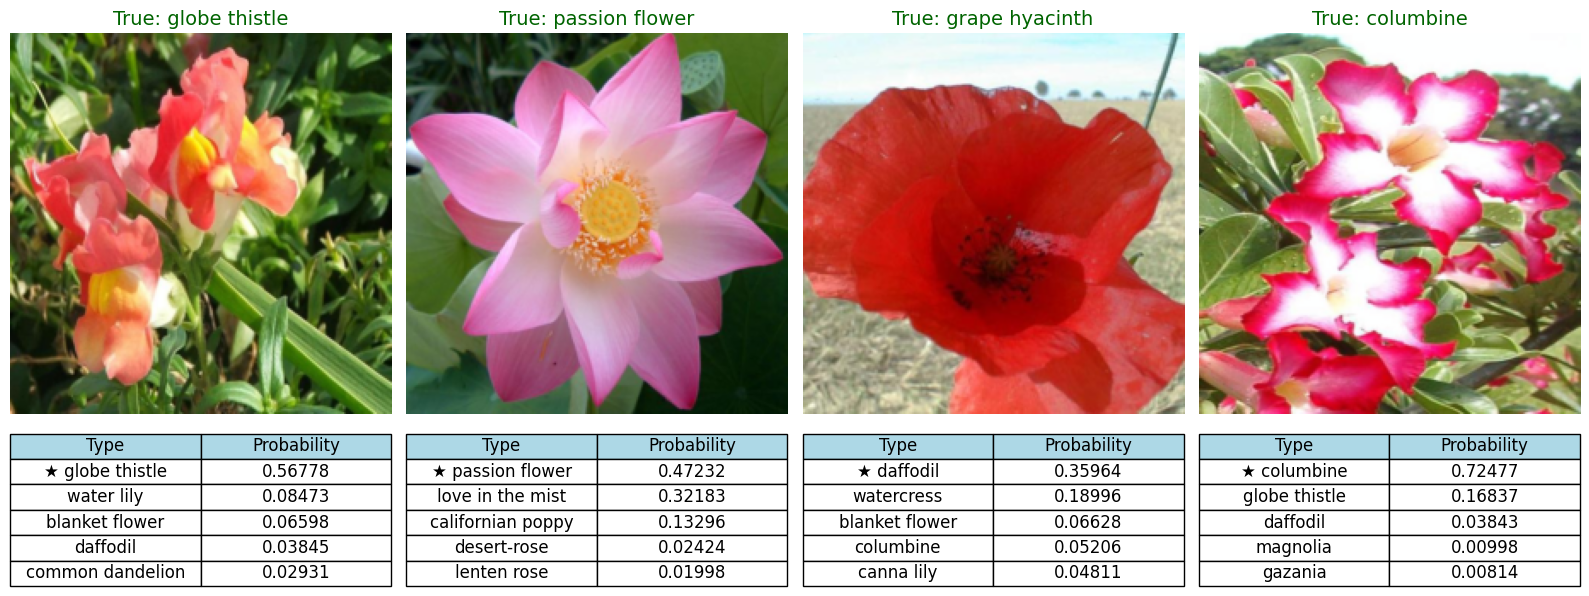

In [ ]:
# ==============================
# Imports
# ==============================
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# ==============================
# Device
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==============================
# Extract test split from split_data2
# ==============================
(x_train, y_train), (x_val, y_val), (x_test, y_test) = split_data2

# ==============================
# Load trained model (seed2)
# ==============================
model = build_vgg19(cfg.num_classes)
model.load_state_dict(
    torch.load(
        f"artifacts/vgg19_repeat_{seed2}/weights.pth",
        map_location=device
    )
)
model.to(device)
model.eval()

# ==============================
# Recreate test dataset & loader
# ==============================
_, eval_tf = get_transforms(cfg.img_size)

test_dataset = PathDataset(x_test, y_test, eval_tf)

test_loader = DataLoader(
    test_dataset,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=True
)

# ==============================
# Visualization
# ==============================
num_images_to_display = 4
random_indices = np.random.choice(len(test_dataset), num_images_to_display, replace=False)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

fig, axes = plt.subplots(1, num_images_to_display, figsize=(num_images_to_display * 4, 5))
if num_images_to_display == 1:
    axes = [axes]

for i, idx in enumerate(random_indices):
    image_tensor, true_label = test_dataset[idx]

    # Unnormalize image
    img = image_tensor.numpy().transpose(1, 2, 0)
    img = std * img + mean
    img = np.clip(img, 0, 1)

    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(
        f"True: {FLOWER_NAMES[str(true_label)]}",
        fontsize=14,
        color="darkgreen"
    )

    with torch.no_grad():
        logits = model(image_tensor.unsqueeze(0).to(device))
        probs = torch.softmax(logits, dim=1)
        top5_prob, top5_idx = torch.topk(probs, 5)

    table_data = []
    for j in range(5):
        cls = top5_idx[0, j].item()
        name = FLOWER_NAMES[str(cls)]
        if j == 0:
            name = f"★ {name}"
        table_data.append([name, f"{top5_prob[0, j].item():.5f}"])

    table = axes[i].table(
        cellText=table_data,
        colLabels=["Type", "Probability"],
        loc="bottom",
        cellLoc="center",
        colColours=["lightblue", "lightblue"],
        bbox=[0, -0.45, 1, 0.4]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)

plt.tight_layout()
plt.show()
